<h1 id="Kaggle-Digit-Recognizer ">Kaggle Digit Recognizer&nbsp;</h1>

<h2 id="MNIST-Image-Classification with-Keras-CNN-model">MNIST Image Classification&nbsp;with Keras (TF2.0) CNN model</h2>

<p>procedure:</p>

<ol>
	<li>Image input from local data, normalized and reshape input to [-1, HEIGHT, WIDTH, 1]</li>
	<li>data&nbsp;augmentation</li>
	<li>CNN model, ir = 0.001 with decrease schedule</li>
	<li>train for 20 &nbsp;- 30 epochs</li>
</ol>

<p>&nbsp;</p>

<p>&nbsp;</p>


In [0]:
!pip install --upgrade tensorflow

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydot
import os

from sklearn.model_selection import train_test_split


import tensorflow as tf
print(tf.__version__)


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

2.0.0


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

<h2 id="Exploring-and-processing data">Exploring and processing&nbsp;data</h2>


In [0]:
gdrive="/content/gdrive/My Drive/Colab Notebooks/"
train = pd.read_csv(gdrive + 'kaggle/digit_recognizer/data/train.csv')
test = pd.read_csv(gdrive + 'kaggle/digit_recognizer/data/test.csv')
#sample_submission = pd.read_csv('data/sample_submission.csv')

In [0]:
#sample_submission.head()

In [0]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train.label.count()

42000

In [0]:
train_images = train.drop(labels = ["label"],axis = 1)
train_labels = train["label"]


In [0]:
train_images = train_images.to_numpy()/255.0
test_images = test.to_numpy()/255.0


In [0]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

In [0]:
train_images = train_images.reshape(-1,HEIGHT,WIDTH,1)
test_images = test_images.reshape(-1,HEIGHT,WIDTH,1)

train_labels = keras.utils.to_categorical(train_labels, num_classes = NCLASSES)

In [0]:
train_labels[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

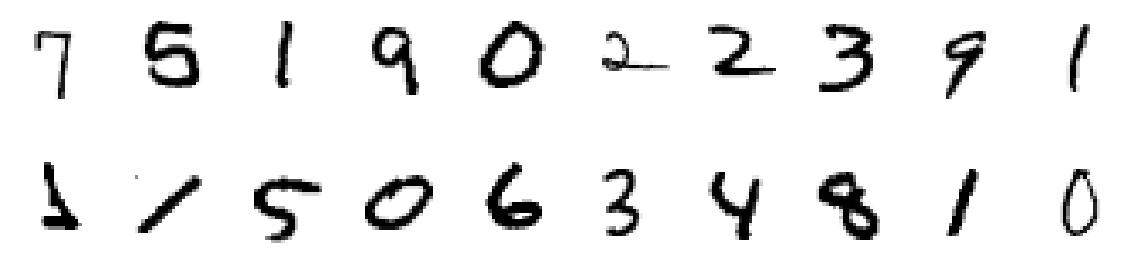

In [0]:
i = 50
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(train_images[IMGNO].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.axis('off')

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size = 0.1)

len(Y_train)

37800

### Data augmentation

In [0]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

datagen.fit(X_train)

## CNN model with Keras functional API


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu', input_shape=(HEIGHT, WIDTH, 1)),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=NCLASSES, activation='softmax')
])

In [33]:
print(model.summary())

#keras.utils.plot_model(model, to_file='digit-cnn-keras_graph.png')

#display(Image.open('digit-cnn-keras_graph.png'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

<h3>train model</h3>


In [0]:
# no augmentation
#history= model.fit(X_train, Y_train, 
#            batch_size = 100,
#            epochs=20,
#            verbose=1, 
#            validation_data = (X_val, Y_val) 
#            )
    

In [35]:
# with augmentation
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
batch_size = 100
epochs = 30
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_val,Y_val),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[annealer]) 

Epoch 1/30
378/378 [==============================] - 77s 204ms/step - loss: 0.5461 - accuracy: 0.8254 - val_loss: 0.0943 - val_accuracy: 0.9690
Epoch 2/30
378/378 [==============================] - 76s 202ms/step - loss: 0.1698 - accuracy: 0.9481 - val_loss: 0.0647 - val_accuracy: 0.9798
Epoch 3/30
378/378 [==============================] - 76s 200ms/step - loss: 0.1183 - accuracy: 0.9633 - val_loss: 0.0486 - val_accuracy: 0.9826
Epoch 4/30
378/378 [==============================] - 76s 201ms/step - loss: 0.0953 - accuracy: 0.9713 - val_loss: 0.0422 - val_accuracy: 0.9867
Epoch 5/30
378/378 [==============================] - 76s 202ms/step - loss: 0.0844 - accuracy: 0.9744 - val_loss: 0.0433 - val_accuracy: 0.9864
Epoch 6/30
378/378 [==============================] - 76s 202ms/step - loss: 0.0741 - accuracy: 0.9768 - val_loss: 0.0375 - val_accuracy: 0.9879
Epoch 7/30
378/378 [==============================] - 76s 202ms/step - loss: 0.0692 - accuracy: 0.9797 - val_loss: 0.0328 - val_ac

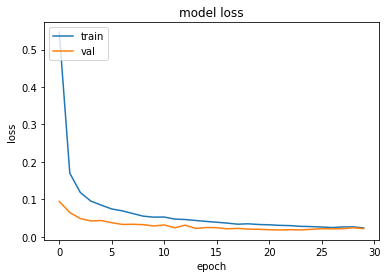

loss: 0.0217   


In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("loss: {0:.4f}   ".format(history.history['val_loss'][-1]))

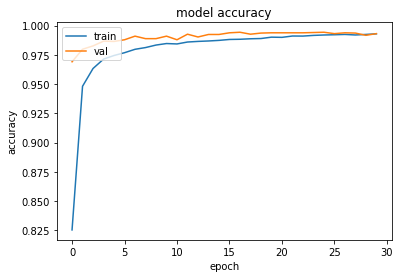

Acc: 0.9931  


In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("Acc: {0:.4f}  ".format(history.history['val_accuracy'][-1],))

### Prediction

In [38]:
pred = model.predict(test_images, batch_size=2000, 
                       verbose=1)
pred = np.argmax(pred, axis=1)

28000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

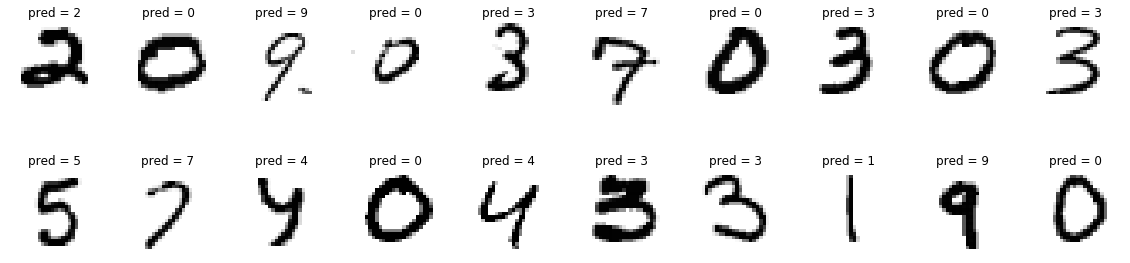

In [39]:
i=0
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(test_images[IMGNO].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("pred = %d" % pred[IMGNO],y=0.9)
    plt.axis('off')
#plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [40]:
pred[:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

## Output

In [41]:
output = pd.DataFrame({ 'ImageId' : np.arange(len(pred))+1, 'Label': pred })
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [0]:
#output.to_csv('data/sub_digit_cnn_keras_tf2_30ep.csv', index = False)


In [0]:
#model.save("data/sub_digit_cnn_keras_tf2.h5")

<p>Score board</p>

<table border="2" cellpadding="1" cellspacing="1" style="width: 500px">
	<tbody>
		<tr>
			<td><strong>kaggle score</strong></td>
			<td><strong>rank</strong></td>
			<td><strong>data augmentation</strong></td>
			<td><strong>batch norm</strong></td>
			<td><strong>epochs</strong></td>
		</tr>
		<tr>
			<td>0.99057</td>
			<td>&nbsp;</td>
			<td>No</td>
			<td>No</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99185</td>
			<td>1017</td>
			<td>No</td>
			<td>Yes</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99257</td>
			<td>910</td>
			<td>Yes</td>
			<td>No</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99457</td>
			<td>655</td>
			<td>Yes</td>
			<td>No</td>
			<td>30</td>
		</tr>
	</tbody>
</table>

<p>&nbsp;</p>




<h2>Credits</h2>

<p><a href="https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist" target="_blank">https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist</a></p>

<p><a href="https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras" target="_blank">https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras</a></p>

https://www.tensorflow.org/guide/keras

